In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import albumentations as A

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib


COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
import cv2
import imageio

import multiprocessing
from joblib import Parallel, delayed
from tqdm import trange
from tqdm import tqdm

import time
from sys import getsizeof
from IPython.display import clear_output

In [2]:
import models.selim_zoo.unet as models

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = models.DensenetUnet(seg_classes=2, backbone_arch='densenet121')
model = models.Resnet(seg_classes=2, backbone_arch='resnet34')
model = model.to(device)
print(device)

cuda


In [5]:
img_size = 512
aug_train = A.Compose([A.Resize(img_size, img_size, interpolation=1, p=1),
                A.ShiftScaleRotate(always_apply=False, p=0.1, shift_limit=(-0.059, 0.050), scale_limit=(-0.1, 0.07), rotate_limit=(-29, 29), interpolation=0, border_mode=1, value=(0, 0, 0), mask_value=None),
                A.Blur(always_apply=False, p=0.07, blur_limit=(3, 5)),
                A.GridDistortion(always_apply=False, p=0.07, num_steps=5, distort_limit=(-0.3, 0.3), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
                A.GridDropout(ratio= 0.01, p=0.1),
                A.GaussNoise(var_limit=(0, 0.001),p=0.1),
                A.Downscale(p=0.13, scale_min=0.4, scale_max=0.75, interpolation=0)

                ], p=1)
aug_test = A.Compose([A.Resize(img_size, img_size, interpolation=1, p=1)], p=1)  

In [6]:
def img_with_masks(img, masks, alpha, return_colors = False):
    '''
    returns image with masks, 
    img - numpy array of image 
    masks - list of masks. Maximum 6 masks. only 0 and 1 allowed
    alpha - int transparency [0:1] 
    return_colors returns list of names of colors of each mask 
    '''
    colors = [
              [255,0,0],  
              [0,255,0],  
              [0,0,255],  
              [255,255,0],
              [0,255,255],
              [102,51,0]  
             ]
    color_names = [
        'Red',
        'greed',
        'BLue',
        'Yello',
        'Light',
        'Brown'  
    ]
    img = img - img.min()
    img = img /(img.max() - img.min())
    img *= 255
    img = img.astype(np.uint8)

    c = 0
    for mask in masks:
        mask = np.dstack((mask, mask, mask)) * np.array(colors[c])
        mask = mask.astype(np.uint8)
        img = cv2.addWeighted(mask,alpha, img, 1, 0.)
        c = c+1
    if return_colors ==False:
        return img
    else:
        return img, color_names[0:len(masks)]
    #**(1/len(masks))

In [7]:
model.load_state_dict(torch.load('experiments/resnet34/model_checkpoints/resnet34_epoch6.pth'))

<All keys matched successfully>

In [8]:
def inference(img_path, thresh = 0.2):
    model.eval();
    image = cv2.imread(f'{img_path}')
    image = (image-image.min())/(image.max()-image.min())
    augs = aug_test(image = image)
    image = augs['image'].transpose((2,0,1))
    im = augs['image']
    image = np.expand_dims(image, axis = 0)
    image = torch.tensor(image)

    mask = torch.nn.Sigmoid()(model(image.float().cuda()))
    mask = mask[0,:,:,:].cpu().detach().numpy()
    mask = (mask>thresh).astype('uint8')
    return im, mask

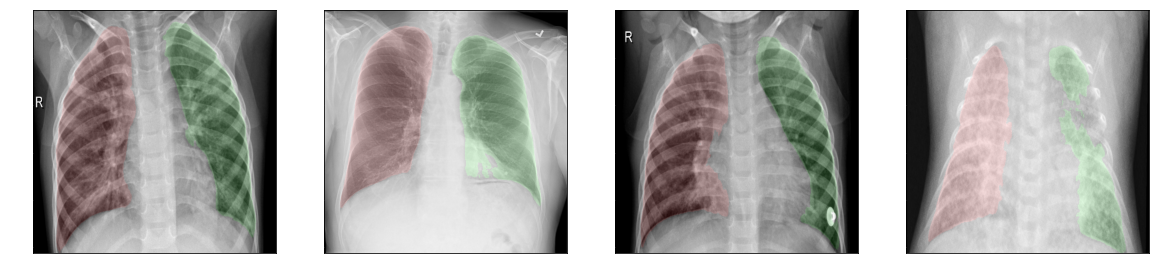

In [9]:
plt.figure(figsize=(20,40))

plt.subplot(1,4,1)
image, mask = inference('test/1.jpeg', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,2)
image, mask = inference('test/2.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,3)
image, mask = inference('test/3.jpeg', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,4)
image, mask = inference('test/4.jpeg', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

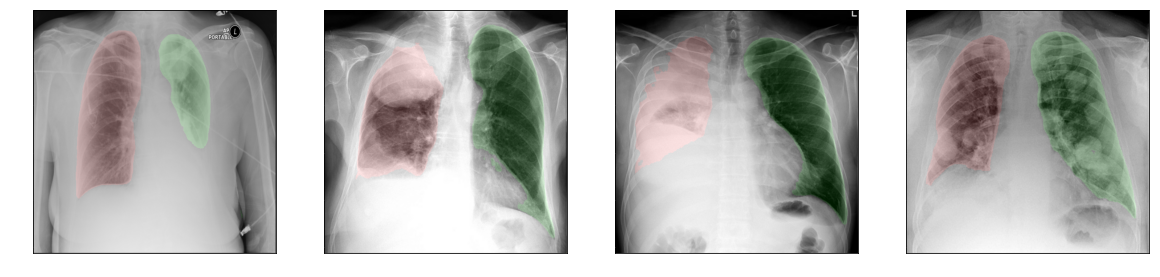

In [10]:
plt.figure(figsize=(20,40))

plt.subplot(1,4,1)
image, mask = inference('test/00013659_019.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,2)
image, mask = inference('test/mass.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,3)
image, mask = inference('test/progress_5.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,4)
image, mask = inference('test/rcc_cannonball_mets.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

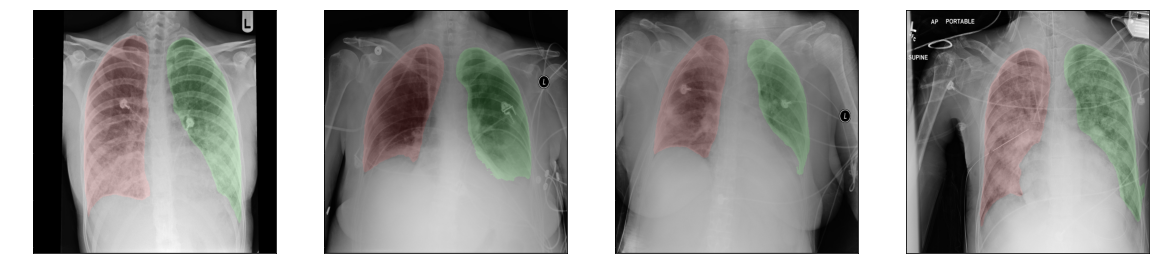

In [11]:
plt.figure(figsize=(20,40))

plt.subplot(1,4,1)
image, mask = inference('test/test_viz/im/LUNG_1.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,2)
image, mask = inference('test/test_viz/im/LUNG_2.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,3)
image, mask = inference('test/test_viz/im/LUNG_3.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,4)
image, mask = inference('test/test_viz/im/LUNG_4.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

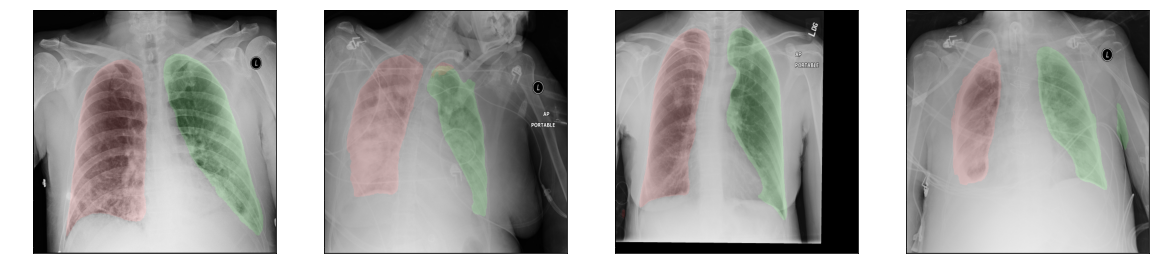

In [12]:
plt.figure(figsize=(20,40))

plt.subplot(1,4,1)
image, mask = inference('test/test_viz/im/LUNG_5.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,2)
image, mask = inference('test/test_viz/im/LUNG_6.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,3)
image, mask = inference('test/test_viz/im/LUNG_7.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,4)
image, mask = inference('test/test_viz/im/LUNG_8.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

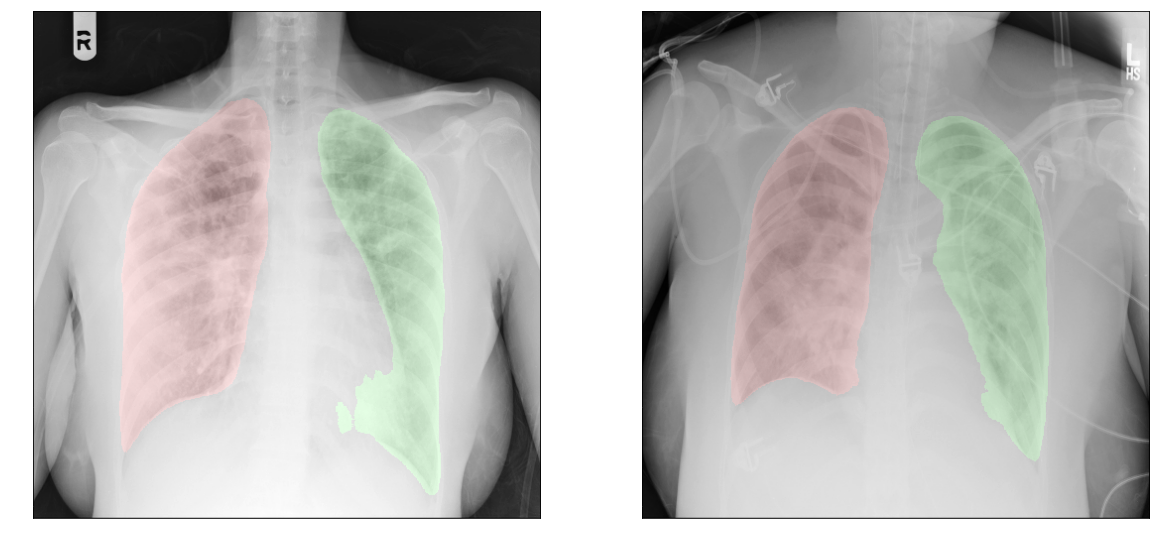

In [13]:
plt.figure(figsize=(20,40))

plt.subplot(1,2,1)
image, mask = inference('test/test_viz/im/LUNG_9.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,2,2)
image, mask = inference('test/test_viz/im/LUNG_10.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))